<a href="https://colab.research.google.com/github/mustafabozkaya/AI-ML-DL-DS_Projects_Portfolio/blob/master/Conformal/Conformal%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Konformal Tahminleme (Conformal Prediction)

* Konformal tahminleme (conformal prediction) sayesinde makine öğrenmesi modellerinin tahminlerini kalibre edebiliyoruz.

* Başka bir ifade ile modelimizin sonuçlarınan ne ölçüde emin olduğunu öğrenebiliyoruz.

* Konformal tahminleme birçok modele uygulanabilir ve modelin eğitiminden sonra yeni tahminleri değerlendirmek için kullanılır.


* Sınfılandırma, regresyon ve zaman serisi tahimini gibi birçok uygulaması vardır.

* Biz burada sadece sınıflandırma için konformal tahminlemeyi en sade hali ile ele alacağız.

* Daha gelişmiş yöntemleri zamanla inceleyeceğiz ancak bu alanın çok aktif bir araştırma alanı olduğunu ve büyük dil modellerine de uygulandığını belirtelim.

### Konformal Sınıflandırma

Sınıflandırma problemi için kullanacağımız model olasılıksal sonuçlar versin. Örneğin bir yapay sinir ağı ve son katanda "softmax" aktivasyon fonksiyonu olabilir.




Sınıflandırma problemimizde el yazması rakam tanıma olsun.

### İzleyeceğimiz yol şu şekilde:

#### Kalibrasyon Aşaması
* Modeli eğitelim ama daha önceden eğitilmiş bir modeli de kullanabilirz.
* Kalibrasyon kümemiz ile tahminler alalım.
* Bu tahminlerin doğru sınıfa ait olanlarını sadece kullanacağız.
* Sonuçları 1'den çıkaralım.
* Elde ettiğimiz sayıların örneğin %5'lik kısmını atalım.

#### Tahmin Aşaması

* Yeni bir veri için tahmin yaparken %5'lik oranın üzerindeki sınıfları alalım.
* Bazen bir tek sınıf bazen de birden fazla sınıf şartları sağlayabilir.


### Matematiksel olarak ifade edelim

Elimizde eğitilmiş bir model var ve $x$ versi için $\hat{f}(x)$ tahminlerini alabiliyoruz:

$x$ --> $\hat{f}(x)$

Kalibrasyon kümemiz $X_{cal} = {x_1, ..., x_n}$ olsun. Örneğimizde n=360.


İzleyeceğimiz adımlar şöyle:


1.  Eğitilmiş modelden kalibrasyon kümemizin tahminlerini alalım: ${\hat{f}(x_1), ..., \hat{f}(x_n)}$.
2.   Ardından doğru sınıflar için tahminleri alalım:
${\hat{f}(x_1)y_1, ..., \hat{f}(x_n)y_n}$.
3. Skorları hesaplayalım:
$s_1=1−\hat{f}(x_1)y_1, ..., s_n=1−\hat{f}(x_n)y_n$}


Şimdi, güven aralıklarında olduğu gibi $\alpha$ değerini belirleyelim. Öreneğin 0.05 olabilir.

Skorla için bir seviye bulalım: $q_{level}= 1- \frac{1+n}{n}(1-\alpha)$.

Şimdi eşik değerimizi bulalım: bunun için skorların kümesinin $q_level$ kuantilini bulacağız.
$\hat{q}=\text{quantile}(q_{level})$.

Artık kalibrasyon işlemi tamam. Modeli günlük hayatta uygularken yeni veri için şunları yapıyoruz.

Yeni veri $x_{new}$ olsun.

1. Önce $\hat{f}(x_{new})$ hesaplanıyor.
2. Sonra $1- \hat{f}(x_{new})$ skoru bulunuyor.
3. Bu dizin içerisinde $\hat{q}$ eşiğinin üzerindeki sınıfları seçiyoruz.

Teorik olarak bu %95 güvenli bir tahmin oluyor. Yani genel olarak 1-$\alpha$.





In [ ]:
# @title Gerekli Kütüphaneler
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

Veri boyutu (1797, 64)


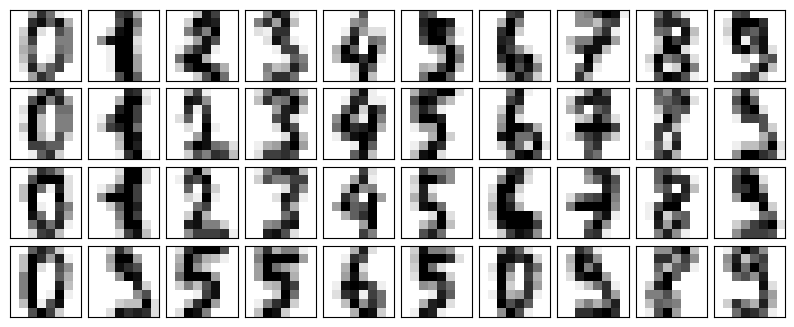

In [ ]:
# @title Veriyi yükleyelim ve bir kısmına bakalım
digits = load_digits()
X = digits.data / 255.
print('Veri boyutu', X.shape)


def plot_digits(data, w=8):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(w, w),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))

plot_digits(digits.data)

In [ ]:
# @title Veriyi eğtim, kalibrasyon ve hiç görmeyeceği veri olarak ayıralım
train_ratio = 0.75
test_ratio = 0.20
validation_ratio = 0.05

X_train, X_cal, y_train, y_cal = train_test_split(X, digits.target, test_size=test_ratio, random_state=10)

X_train, X_new, y_train, y_new = train_test_split(X_train, y_train, test_size=validation_ratio/(train_ratio+test_ratio), random_state=10)


print("Eğitim kümesi", len(X_train), "veri")
print("Kalibrasyon kümesi", len(X_cal), "veri")
print("Kullanılmayan veri", len(X_new), "veri")

Eğitim kümesi 1361 veri
Kalibrasyon kümesi 360 veri
Kullanılmayan veri 76 veri


Yukarıda örneklerini gördüğünüz gibi 1797 tane 8x8 boyutunda resimlerimiz var ama düzleştirilmiş ve 64 boyutlu vektörler oluşmuş.



Şimdi verinin bir kısmını kabirason için ayıralım, %20 olabilir.

Modelimiz 64 girdili ve 10 çıktılı yapay sinir ağı. İki gizli katmanı var ve bunlarda 16'şar nöron bulunuyor. Çıktı aktivasyon fonksiyonumuz "softmax".

In [ ]:
# @title Modeli oluşturalım
inputs = tf.keras.Input((64,))
x = tf.keras.layers.Dense(
    units=32,
    activation='relu'
)(inputs)
x = tf.keras.layers.Dense(
    units=32,
    activation='relu'
)(x)
outputs = tf.keras.layers.Dense(
    units=10,
    activation='softmax'
)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [ ]:
# @title Modelin yapısını görelim
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dense_17 (Dense)            (None, 10)                330       
                                                                 
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# @title Modeli eğitelim
model.fit(
    X_train,
    y_train,
    epochs=20,
    verbose=1
)

Epoch 1/20
43/43 [==============================] - 1s 2ms/step - loss: 2.2906 - sparse_categorical_accuracy: 0.1712
Epoch 2/20
43/43 [==============================] - 0s 2ms/step - loss: 2.2515 - sparse_categorical_accuracy: 0.4291
Epoch 3/20
43/43 [==============================] - 0s 2ms/step - loss: 2.1678 - sparse_categorical_accuracy: 0.5334
Epoch 4/20
43/43 [==============================] - 0s 2ms/step - loss: 2.0192 - sparse_categorical_accuracy: 0.6348
Epoch 5/20
43/43 [==============================] - 0s 2ms/step - loss: 1.7914 - sparse_categorical_accuracy: 0.6561
Epoch 6/20
43/43 [==============================] - 0s 2ms/step - loss: 1.5181 - sparse_categorical_accuracy: 0.7370
Epoch 7/20
43/43 [==============================] - 0s 2ms/step - loss: 1.2651 - sparse_categorical_accuracy: 0.7531
Epoch 8/20
43/43 [==============================] - 0s 2ms/step - loss: 1.0588 - sparse_categorical_accuracy: 0.7972
Epoch 9/20
43/43 [==============================] - 0s 3ms/step 

In [ ]:
# @title Kalibrasyon kümesinin ilk versi için tahmin alalım
np.set_printoptions(precision=5, suppress=True)
predictions = model.predict(X_cal, verbose=0)
model.predict(X_cal, verbose=0)[0]

array([0.00024, 0.0001 , 0.00003, 0.00019, 0.0003 , 0.98026, 0.00021,
       0.01268, 0.00334, 0.00264], dtype=float32)

In [ ]:
# @title Sadece doğru sınıfın olasılığı
n = len(X_cal)
prob_true_class  = predictions[np.arange(n),y_cal]
prob_true_class[0]

0.9802626

In [ ]:
# @title Tüm kalibrasyon kümesinin skorlarını bulalım
scores = 1 - prob_true_class

In [ ]:
# @title Alfa değerini 0.05 alarak eşik değerimizi hesaplayalım
alpha = 0.05
# define quantile
q_level = (n+1)*(1-alpha)/n
qhat = np.quantile(scores, q_level, method='higher')
print("Eşik", qhat)

Eşik 0.7811421


Text(0, 0.5, 'Frequency')

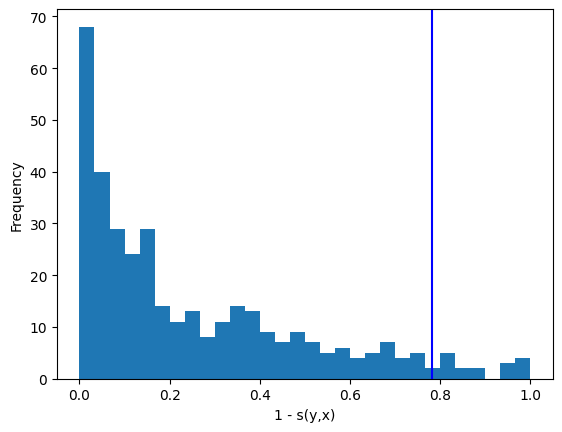

In [ ]:
# @title Skorların dağılımın görelim
import matplotlib.pyplot as plt

# Get the "probabilities" from the model
# Get for each instance the actual probability of ground truth
prob_for_true_class = predictions[np.arange(len(y_cal)),y_cal]
# Create a histogram
plt.hist(1 - prob_for_true_class, bins=30, range=(0, 1))
plt.axvline(x = qhat, color = 'b')
# Add a title and labels
plt.xlabel("1 - s(y,x)")
plt.ylabel("Frequency")

In [ ]:
# @title Kalibrasyonlu tahmin kümelerimizi oluşturalım
prediction_sets = (1 - model.predict(X_new, verbose=0) <= qhat)

In [ ]:
# @title İlk 10 hiç kullanılmamış veri için sonuçları görelim
for i in range(10):
  print(prediction_sets[i])

[False False False False  True False False False False False]
[False False False False False False False  True  True False]
[False  True False False False False False False  True False]
[False False False  True False False False False False False]
[False False False False False False False False False  True]
[False False False False False  True False False False  True]
[ True False False False False False False False False False]
[False False False False False  True False False False False]
[ True False False False False False False False False False]
[False False False False  True False False False False False]


In [ ]:
# @title Altıncı örneğin sonuçlarını görelim
prediction_sets[5]

array([False, False, False, False, False,  True, False, False, False,
        True])

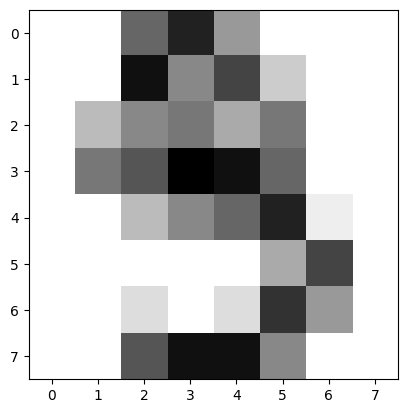

In [ ]:
# @title Altıncı örneğin resmini görelim
plt.imshow(X_new[5].reshape(8, 8), cmap='binary', interpolation='nearest')

In [ ]:
# @title Konformal tahmin fonksiyonunu oluşturalım
def model_cal_pred(x):
  classes = 1 - model.predict(x.reshape(1, 64), verbose=0) <= qhat
  for i in range(10):
    if classes[0][i] == True:
      print("Tahmin: ", i, "Olasılık: ", model.predict(x.reshape(1, 64), verbose=0)[0][i])

In [ ]:
# @title Altıncı örnek için sonuçları görelim
model_cal_pred(X_new[5])

Tahmin:  5 Olasılık:  0.24454334
Tahmin:  9 Olasılık:  0.5566617


### Kaynaklar:
- Books
 * [C. Molnar, Introduction To Conformal Prediction With Python: A Short Guide For Quantifying Uncertainty Of Machine Learning Models](https://christophmolnar.com/books/conformal-prediction/)
- Articles
 * [Robots That Ask For Help: Uncertainty Alignment for Large Language Model Planners]()
- Codes
 * [Awesome Conformal Prediction](https://github.com/valeman/awesome-conformal-prediction)